# ASSIGNMENT 3

In [1]:
# Usual Imports

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
import sklearn.model_selection as skms
from sklearn.metrics import classification_report,confusion_matrix,auc,roc_curve,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import os

In [2]:
adult_df = pd.read_csv('../data/adult.data', header = None, skipinitialspace=True)
adult_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
adult_df.columns = ["age","workclass","fnlwgt","education","education_num","marital_status","occupation","relationship","race","sex","capital_gain","capital_loss","hours_per_week","native_country","salary"]

In [4]:
adult_df.shape

(32561, 15)

In [5]:
adult_df.drop(['fnlwgt'],axis=1,inplace=True)

In [6]:
adult_df['salary'] = np.where(adult_df['salary']=='<=50K',0,1)

In [7]:
X = adult_df.drop(['salary'],axis=1)
y = adult_df['salary'].values
print("X Shape:" + str(X.shape))
print("Y Shape:" + str(y.shape))
print("Values in y: " + str(np.unique(y)))

X Shape:(32561, 13)
Y Shape:(32561,)
Values in y: [0 1]


In [8]:
X_encoded = pd.get_dummies(X)
print("X_Encoded Shape: "+str(X_encoded.shape))
X_encoded.head()


X_Encoded Shape: (32561, 107)


,age,education_num,capital_gain,capital_loss,hours_per_week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,native_country_Portugal,native_country_Puerto-Rico,native_country_Scotland,native_country_South,native_country_Taiwan,native_country_Thailand,native_country_Trinadad&Tobago,native_country_United-States,native_country_Vietnam,native_country_Yugoslavia
0,39,13,2174,0,40,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,50,13,0,0,13,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,38,9,0,0,40,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
3,53,7,0,0,40,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
4,28,13,0,0,40,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [9]:
X_train,X_test,y_train,y_test = skms.train_test_split(X_encoded.to_numpy(),y,test_size=0.30, random_state=42)

In [10]:
print("X Train Shape: "+str(X_train.shape))
print("X Test Shape: "+str(X_test.shape))

X Train Shape: (22792, 107)
X Test Shape: (9769, 107)


## Function to perform operations on a passed model and to plot the model outputs

In [11]:
def plot_model(cnf,cfr,coeff,auc_pd,batch):
    fig_n, axe = plt.subplots(2, 2, figsize=(30, 15))

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_percentages = ["{0:.2%}".format(value) for value in
                         cnf.flatten()/np.sum(cnf)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    cnf = cnf/np.sum(cnf) 
    cfr = pd.DataFrame(cfr).transpose()
    cfr = cfr[['precision', 'recall', 'f1-score','support']]

    confusion_matrix_plots = sns.heatmap(cnf, annot=labels, fmt='', cmap='flare',ax=axe[0][0])
    class_report_plots = sns.heatmap(cfr,cmap='flare',annot=cfr,ax=axe[0][1],fmt='g')
    auc_plot = sns.heatmap(auc_pd,cmap='flare',annot=auc_pd,ax=axe[1][0],fmt='g')
    coeffs = sns.barplot(coeff.iloc[0:5],y="Feature Names",x="Coefficient Value",ax=axe[1][1],palette="flare")

    axe[0][0].set_title("Confusion Matrix for: "+batch)
    axe[0][1].set_title("Classification Report for: "+batch)
    axe[1][0].set_title("AUC Score for: "+batch)
    axe[1][1].set_title("Top 10 Co-Efficients for: "+batch)

def model_results(model,X_train,X_test,y_train,y_test,column_names,grid_search=False,random_search=False,parameters=None):
    
    if grid_search == True and parameters != None:
        print("Grid Search")
        gscv = GridSearchCV(model,param_grid=parameters,cv=5,scoring='roc_auc',n_jobs=os.cpu_count())
        gscv.fit(X_train, y_train)
        y_train_pred = gscv.predict(X_train)
        y_test_pred = gscv.predict(X_test)
        model = gscv.best_estimator_
        feature_values = model.feature_importances_
        predict_proba_auc_train = gscv.predict_proba(X_train)
        predict_proba_auc_test = gscv.predict_proba(X_test)
    elif random_search == True and parameters!=None:
        print("Random Search")
        rcv = RandomizedSearchCV(model,param_distributions=parameters,cv=5,scoring='roc_auc',n_jobs=os.cpu_count())
        rcv.fit(X_train, y_train)
        y_train_pred = rcv.predict(X_train)
        y_test_pred = rcv.predict(X_test)
        model = rcv.best_estimator_
        feature_values = model.feature_importances_
        predict_proba_auc_train = rcv.predict_proba(X_train)
        predict_proba_auc_test = rcv.predict_proba(X_test)
    else:
        print("Standard Model")
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        feature_values = model.feature_importances_
        predict_proba_auc_train = model.predict_proba(X_train)
        predict_proba_auc_test = model.predict_proba(X_test)
    
    coeff_table = pd.DataFrame({"Feature Names": column_names, "Coefficient Value": abs(feature_values)})
    coeff_table = coeff_table.sort_values(by=['Coefficient Value'],ascending=False)
    
    fpr, tpr, thresholds = roc_curve(y_train,predict_proba_auc_train[:,1])
    auc_value = auc(fpr,tpr)
    auc_pd_train = pd.DataFrame({"AUC":[auc_value]})

    fpr, tpr, thresholds = roc_curve(y_test,predict_proba_auc_test[:,1])
    auc_value = auc(fpr,tpr)
    auc_pd_test = pd.DataFrame({"AUC":[auc_value]})

    plot_model(confusion_matrix(y_train, y_train_pred),classification_report(y_train, y_train_pred,output_dict=True),coeff_table,auc_pd_train,"Train")
    plot_model(confusion_matrix(y_test, y_test_pred),classification_report(y_test, y_test_pred,output_dict=True),coeff_table,auc_pd_test,"Test")

    return model,classification_report(y_test, y_test_pred,output_dict=True)

## Random Forest Classifier 

Standard Model


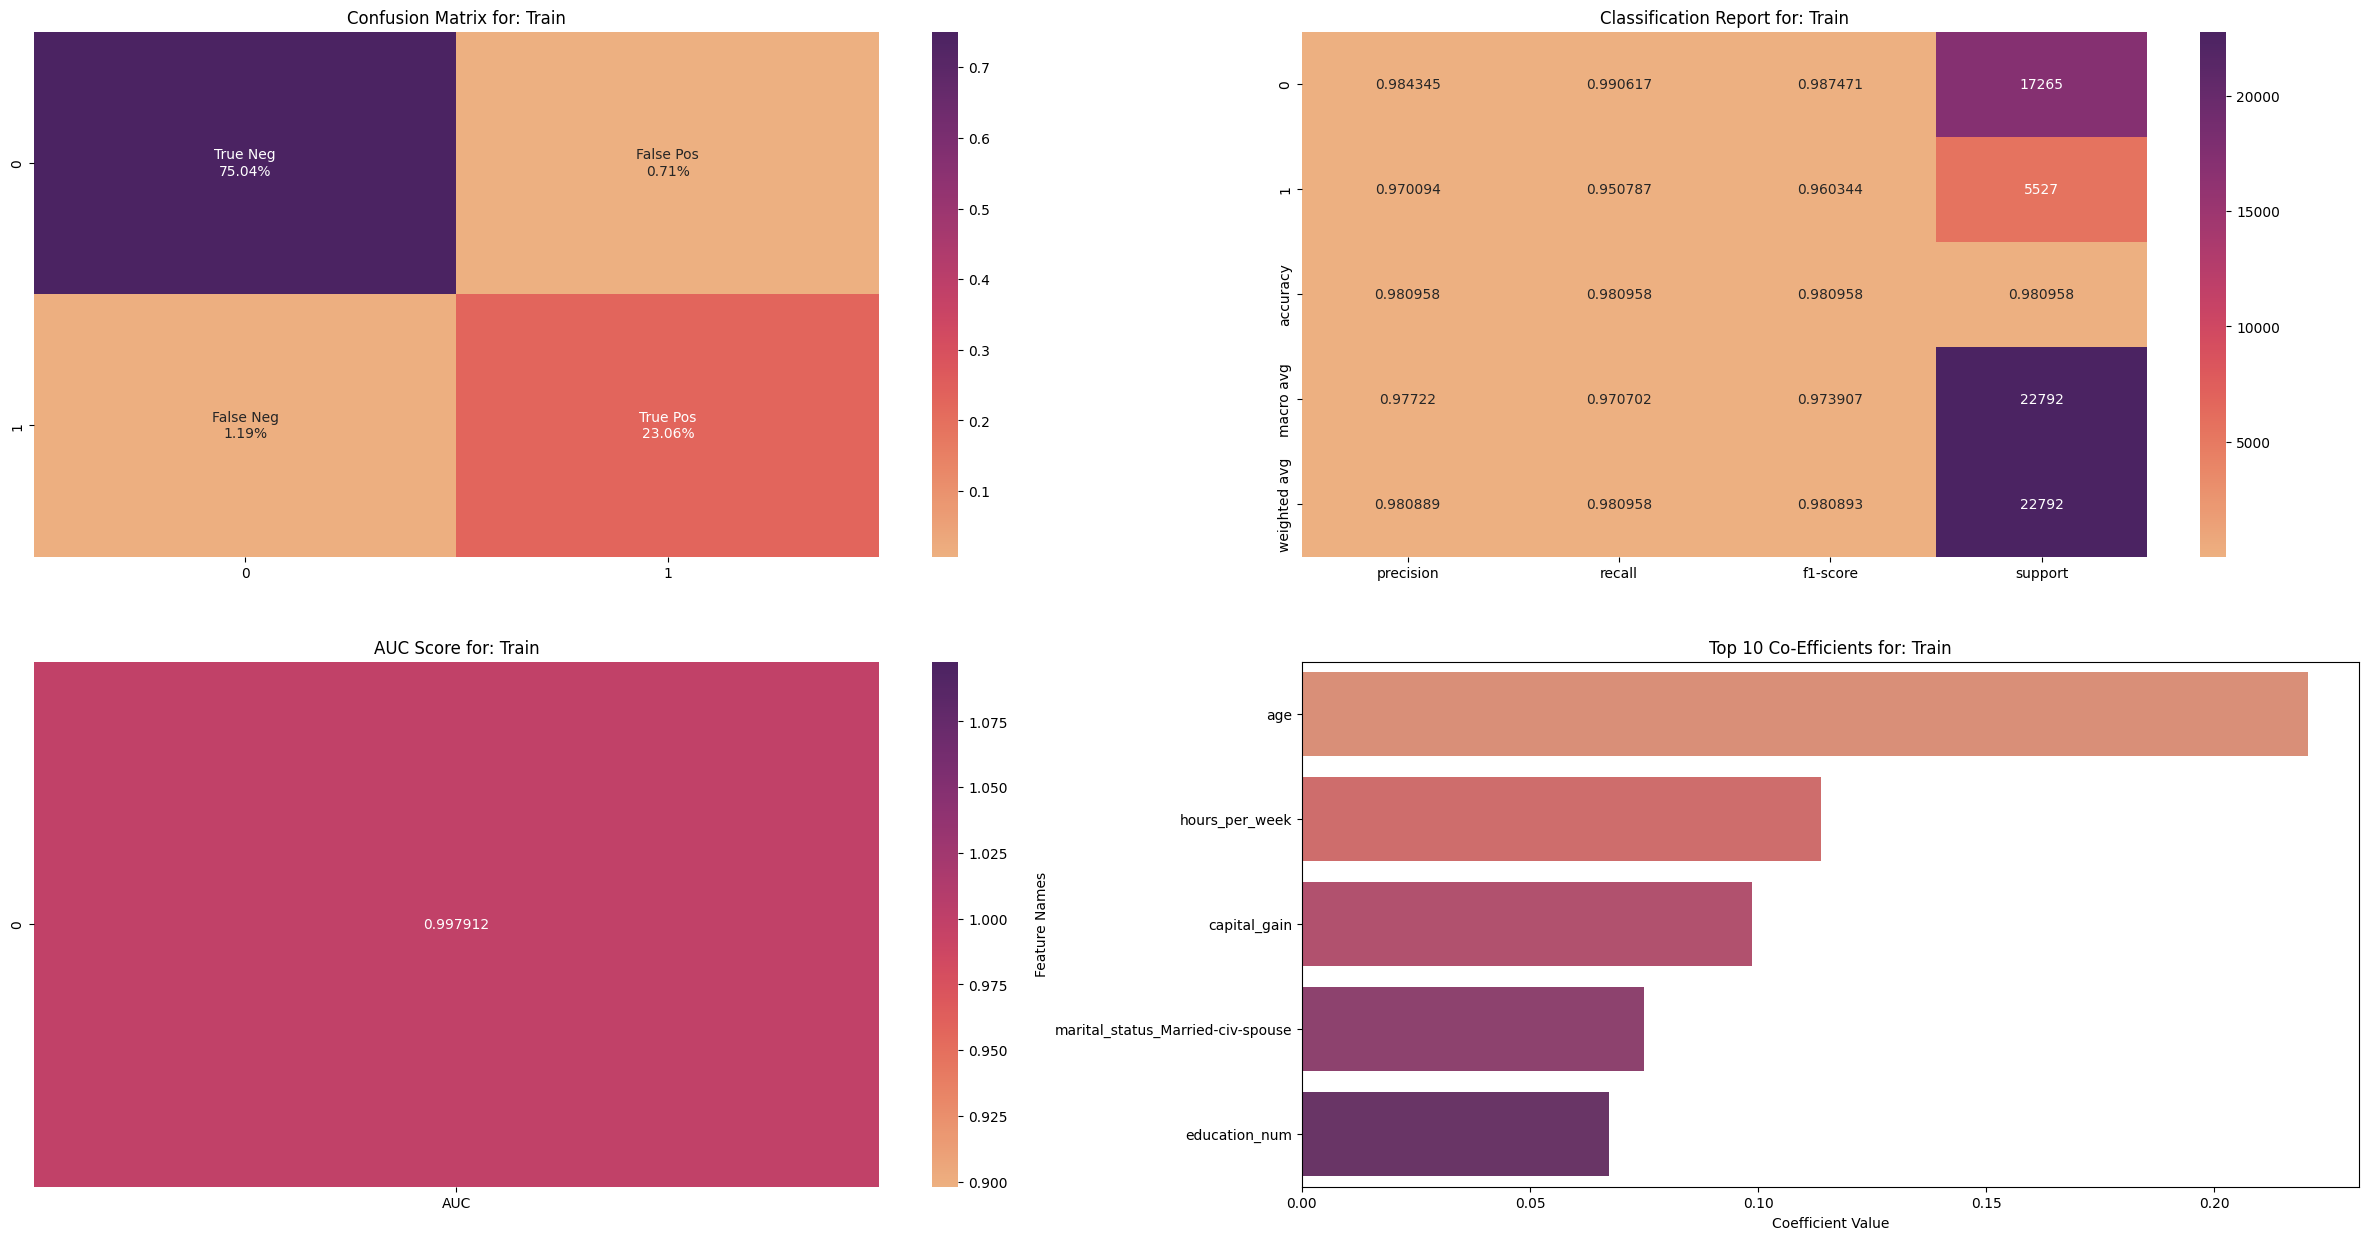

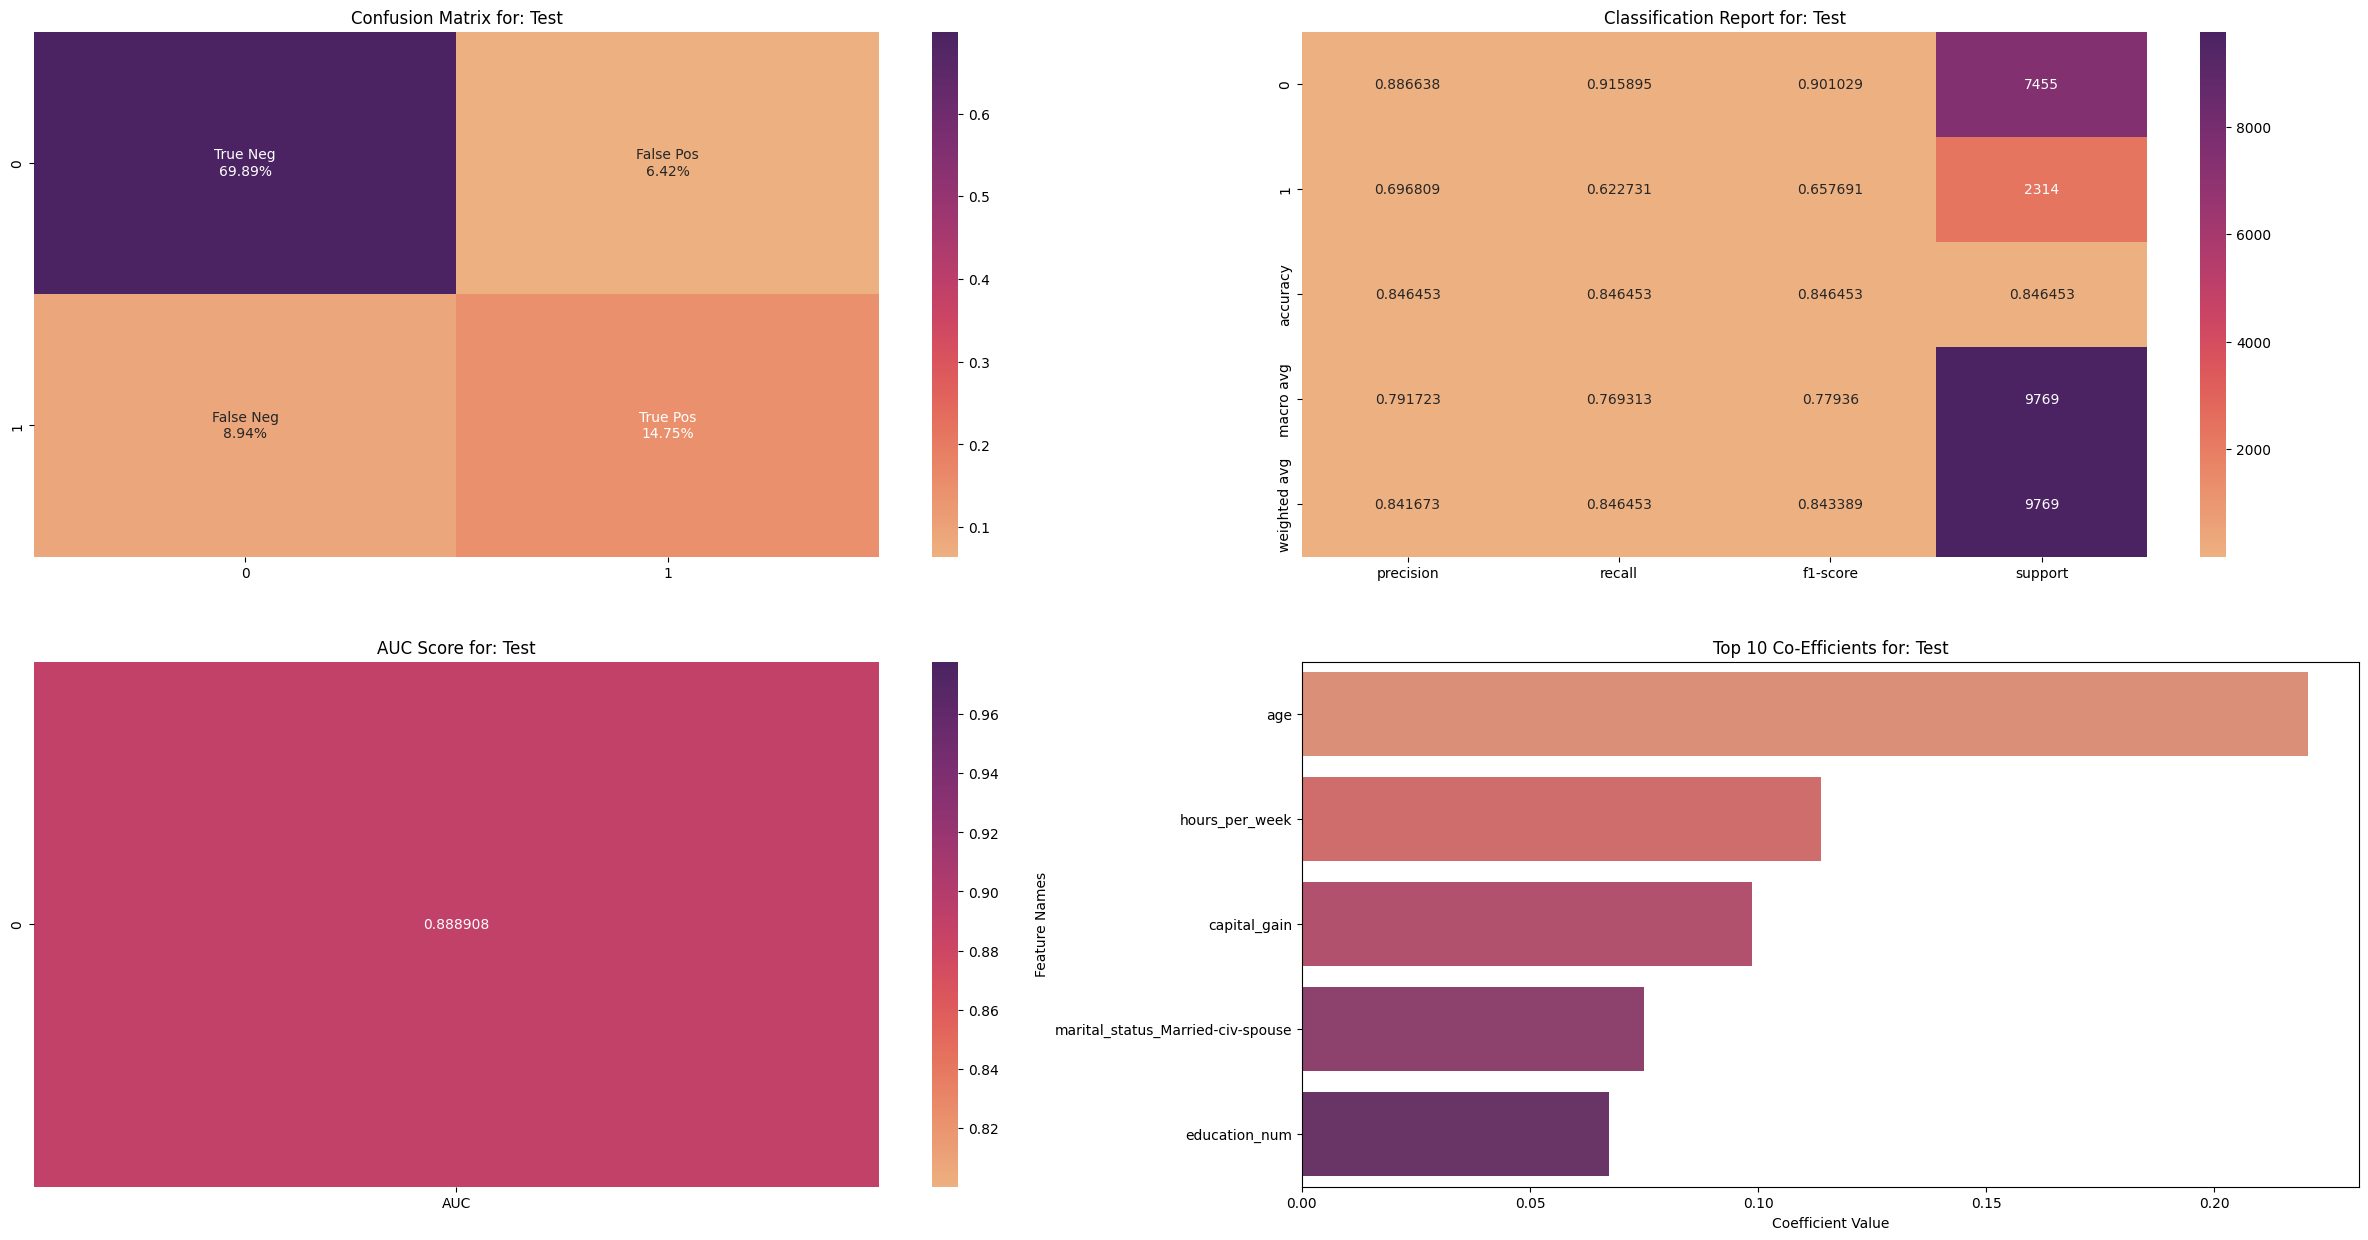

In [12]:
rfc,rfc_coeff_table = model_results(RandomForestClassifier(n_jobs=(math.floor(os.cpu_count()*0.7)),random_state=42),X_train,X_test,y_train,y_test,X_encoded.columns)

As we can see, the model is performing much better on the train data than the test data so we can say it's overfitting

## ADA Boost Classifier

Grid Search


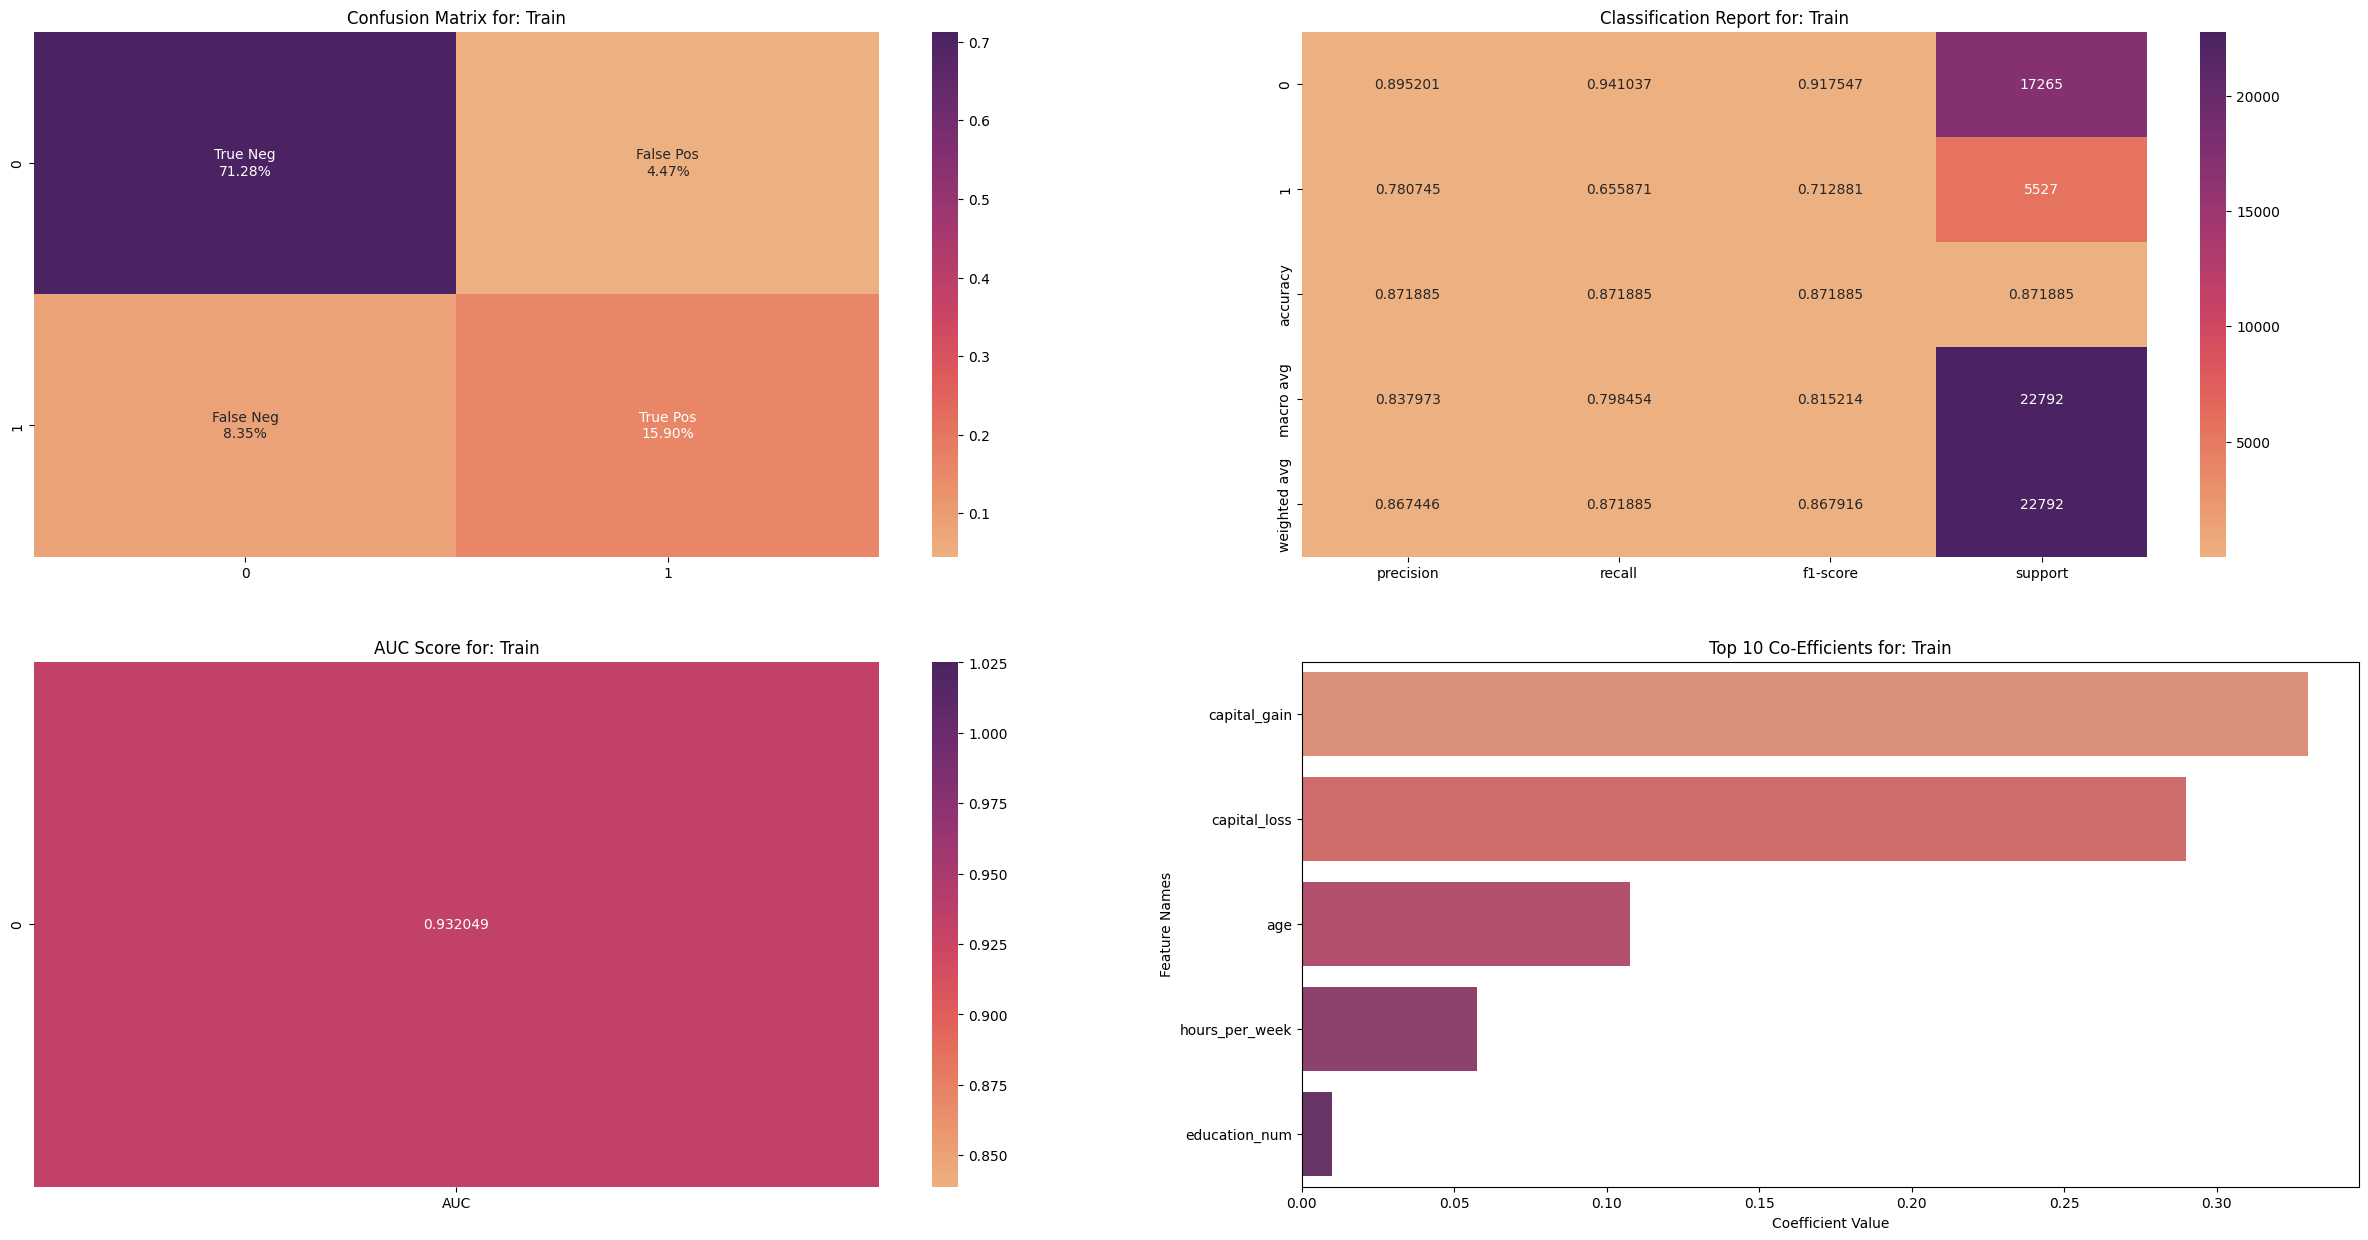

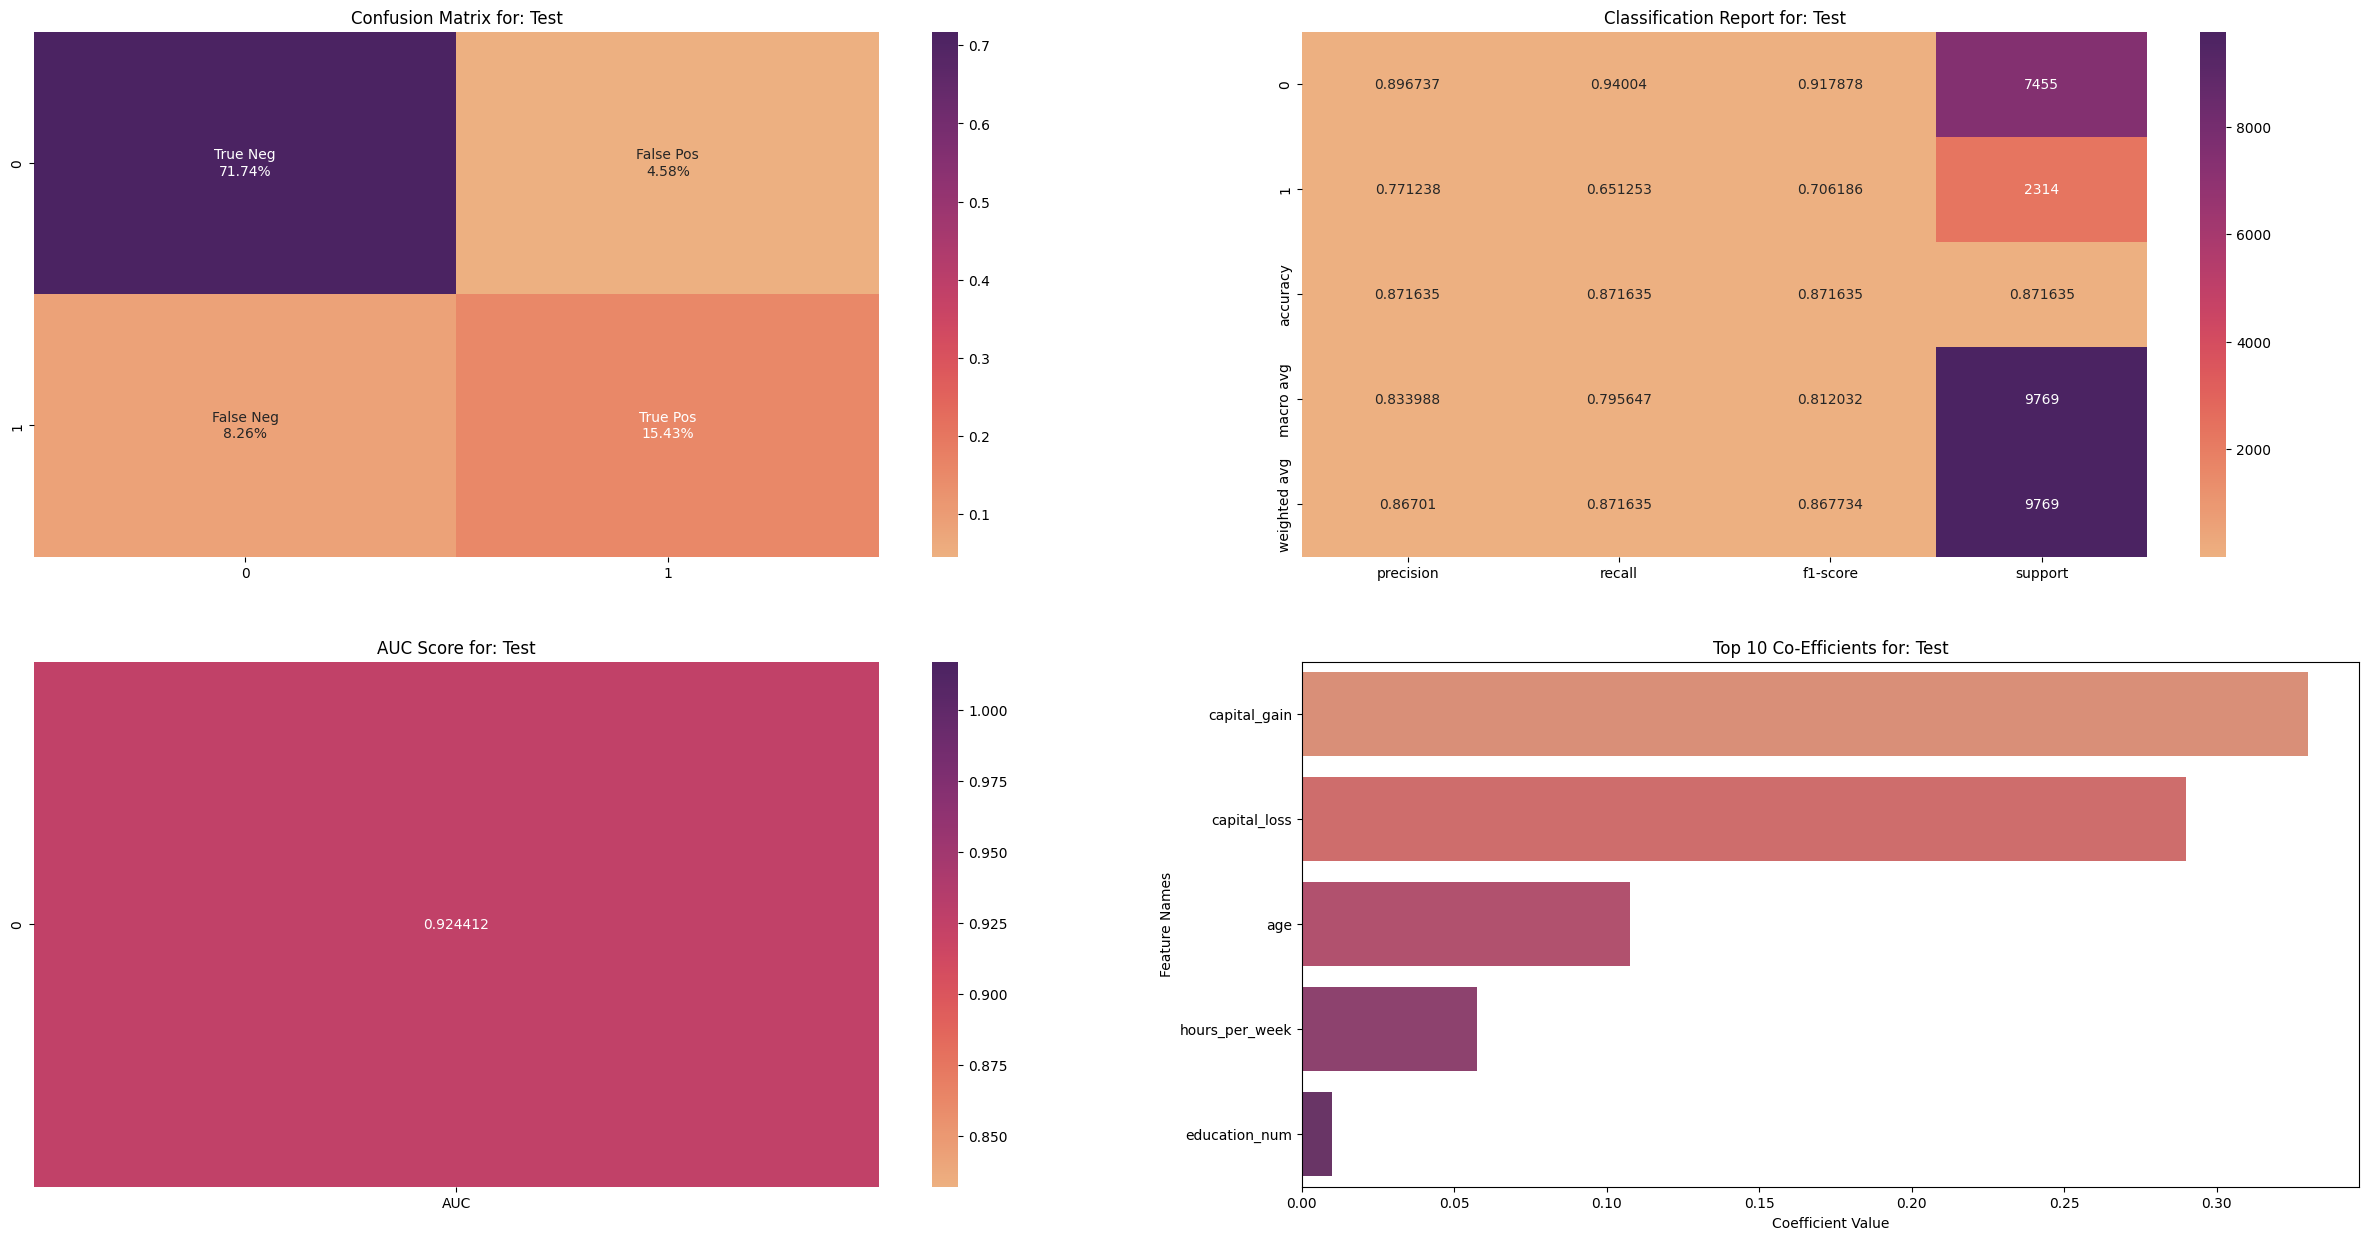

In [13]:
ada,ada_coeff_table = model_results(AdaBoostClassifier(random_state=42),X_train,X_test,y_train,y_test,X_encoded.columns,grid_search=True,random_search=False,parameters=[{"n_estimators":[100,200,300,400],"learning_rate":[0.2,0.4,0.6,0.8,1,1.2]}])

As we can see, the train and test data is simillar. So the model is not overfitting

## Gradient Boosting Classifier

Grid Search


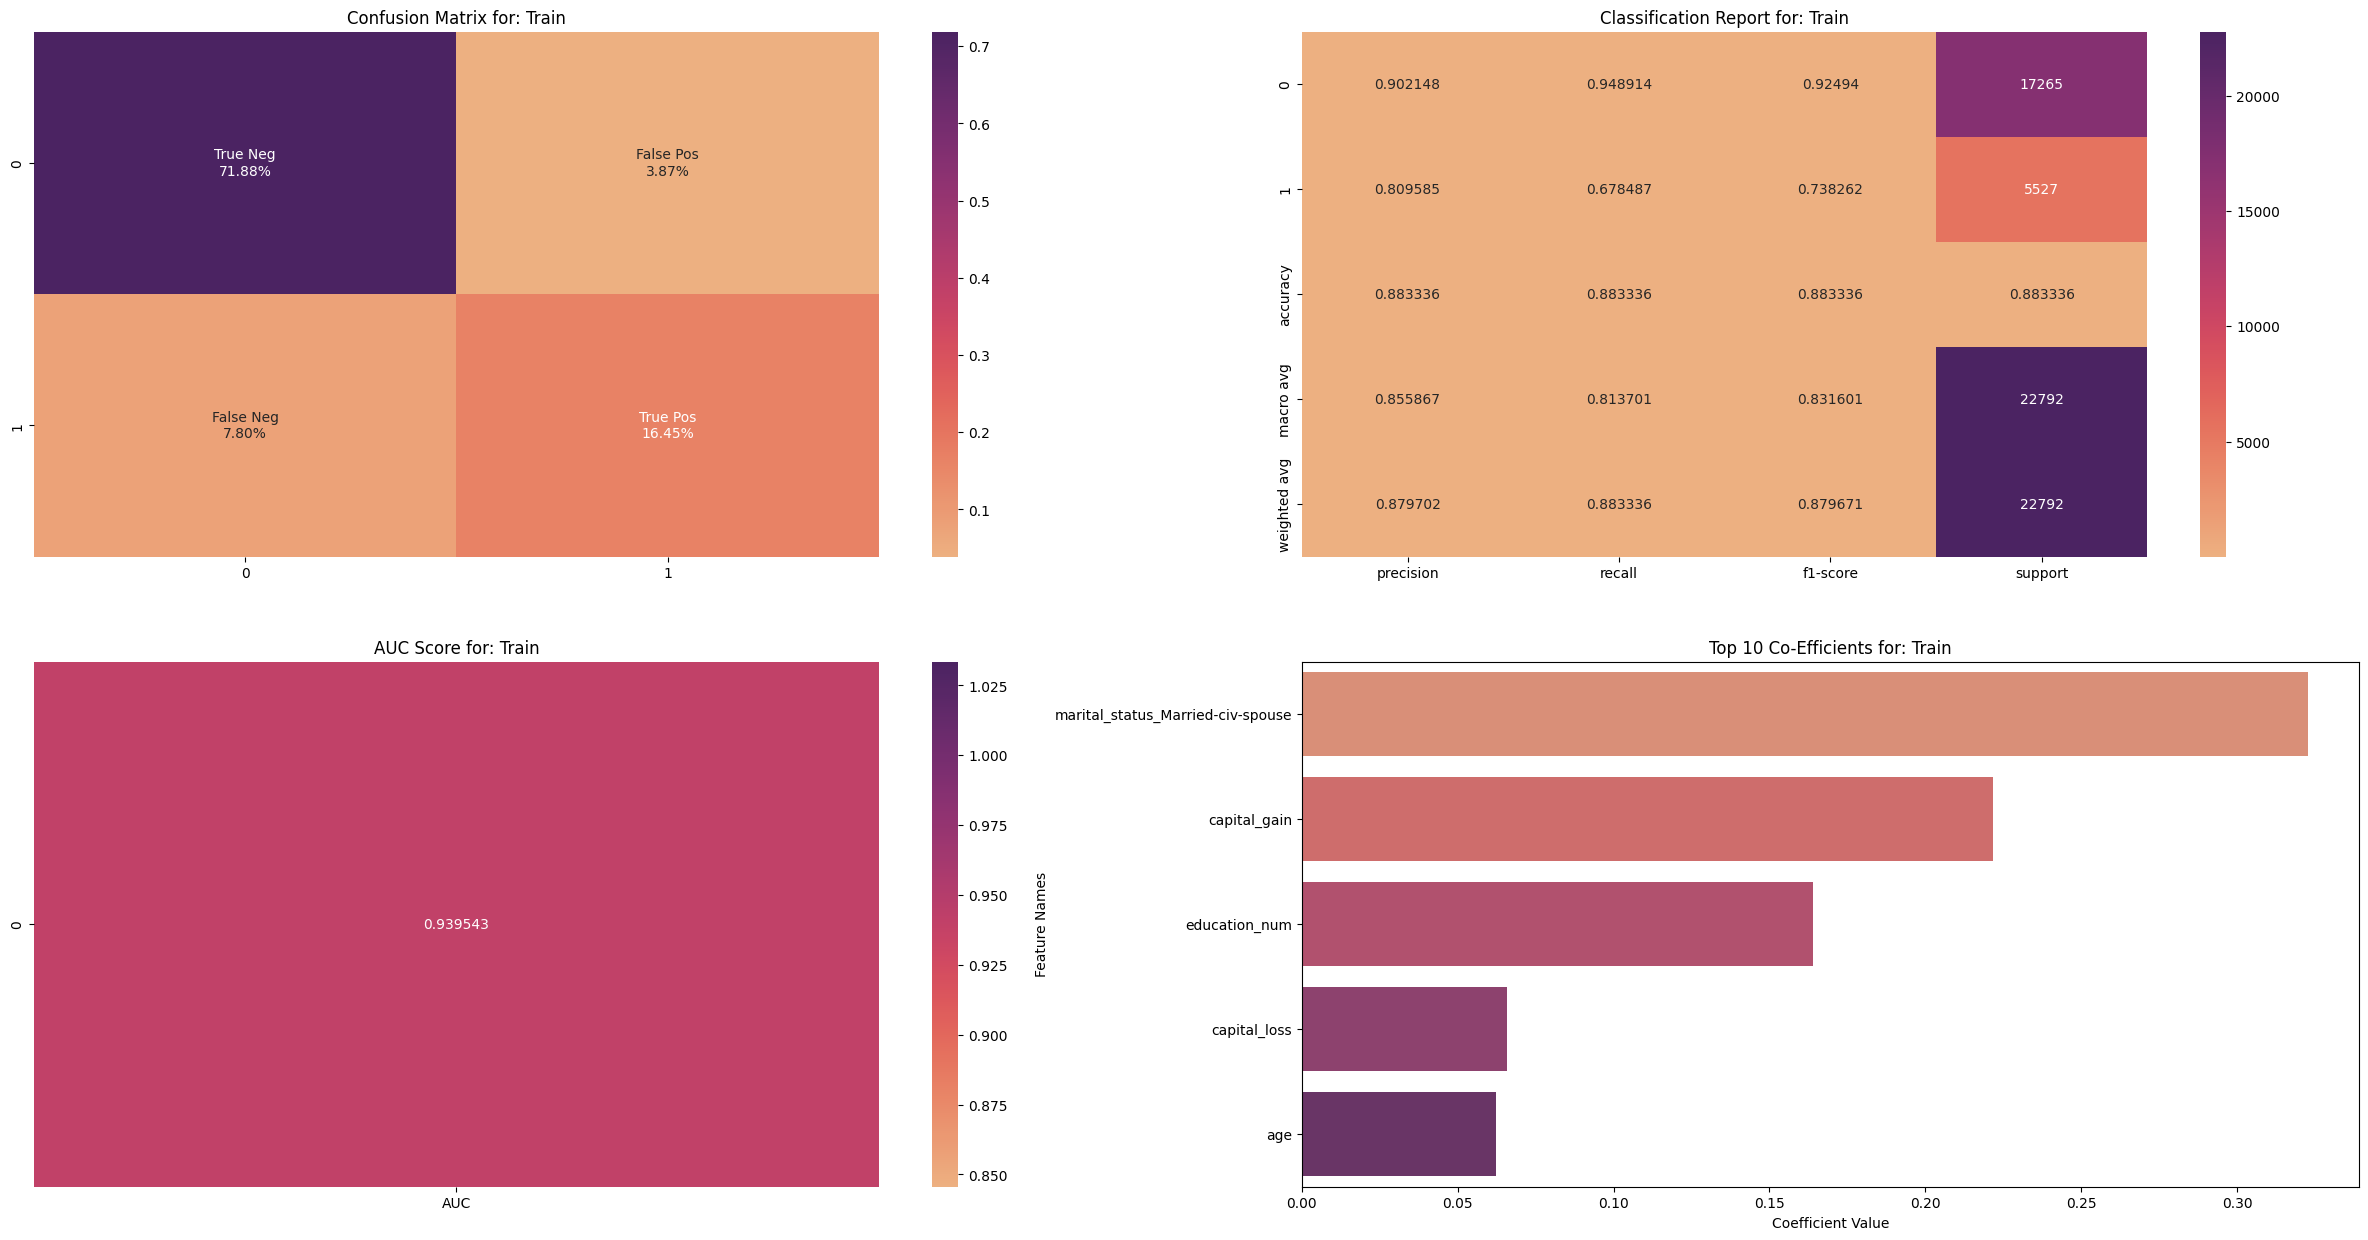

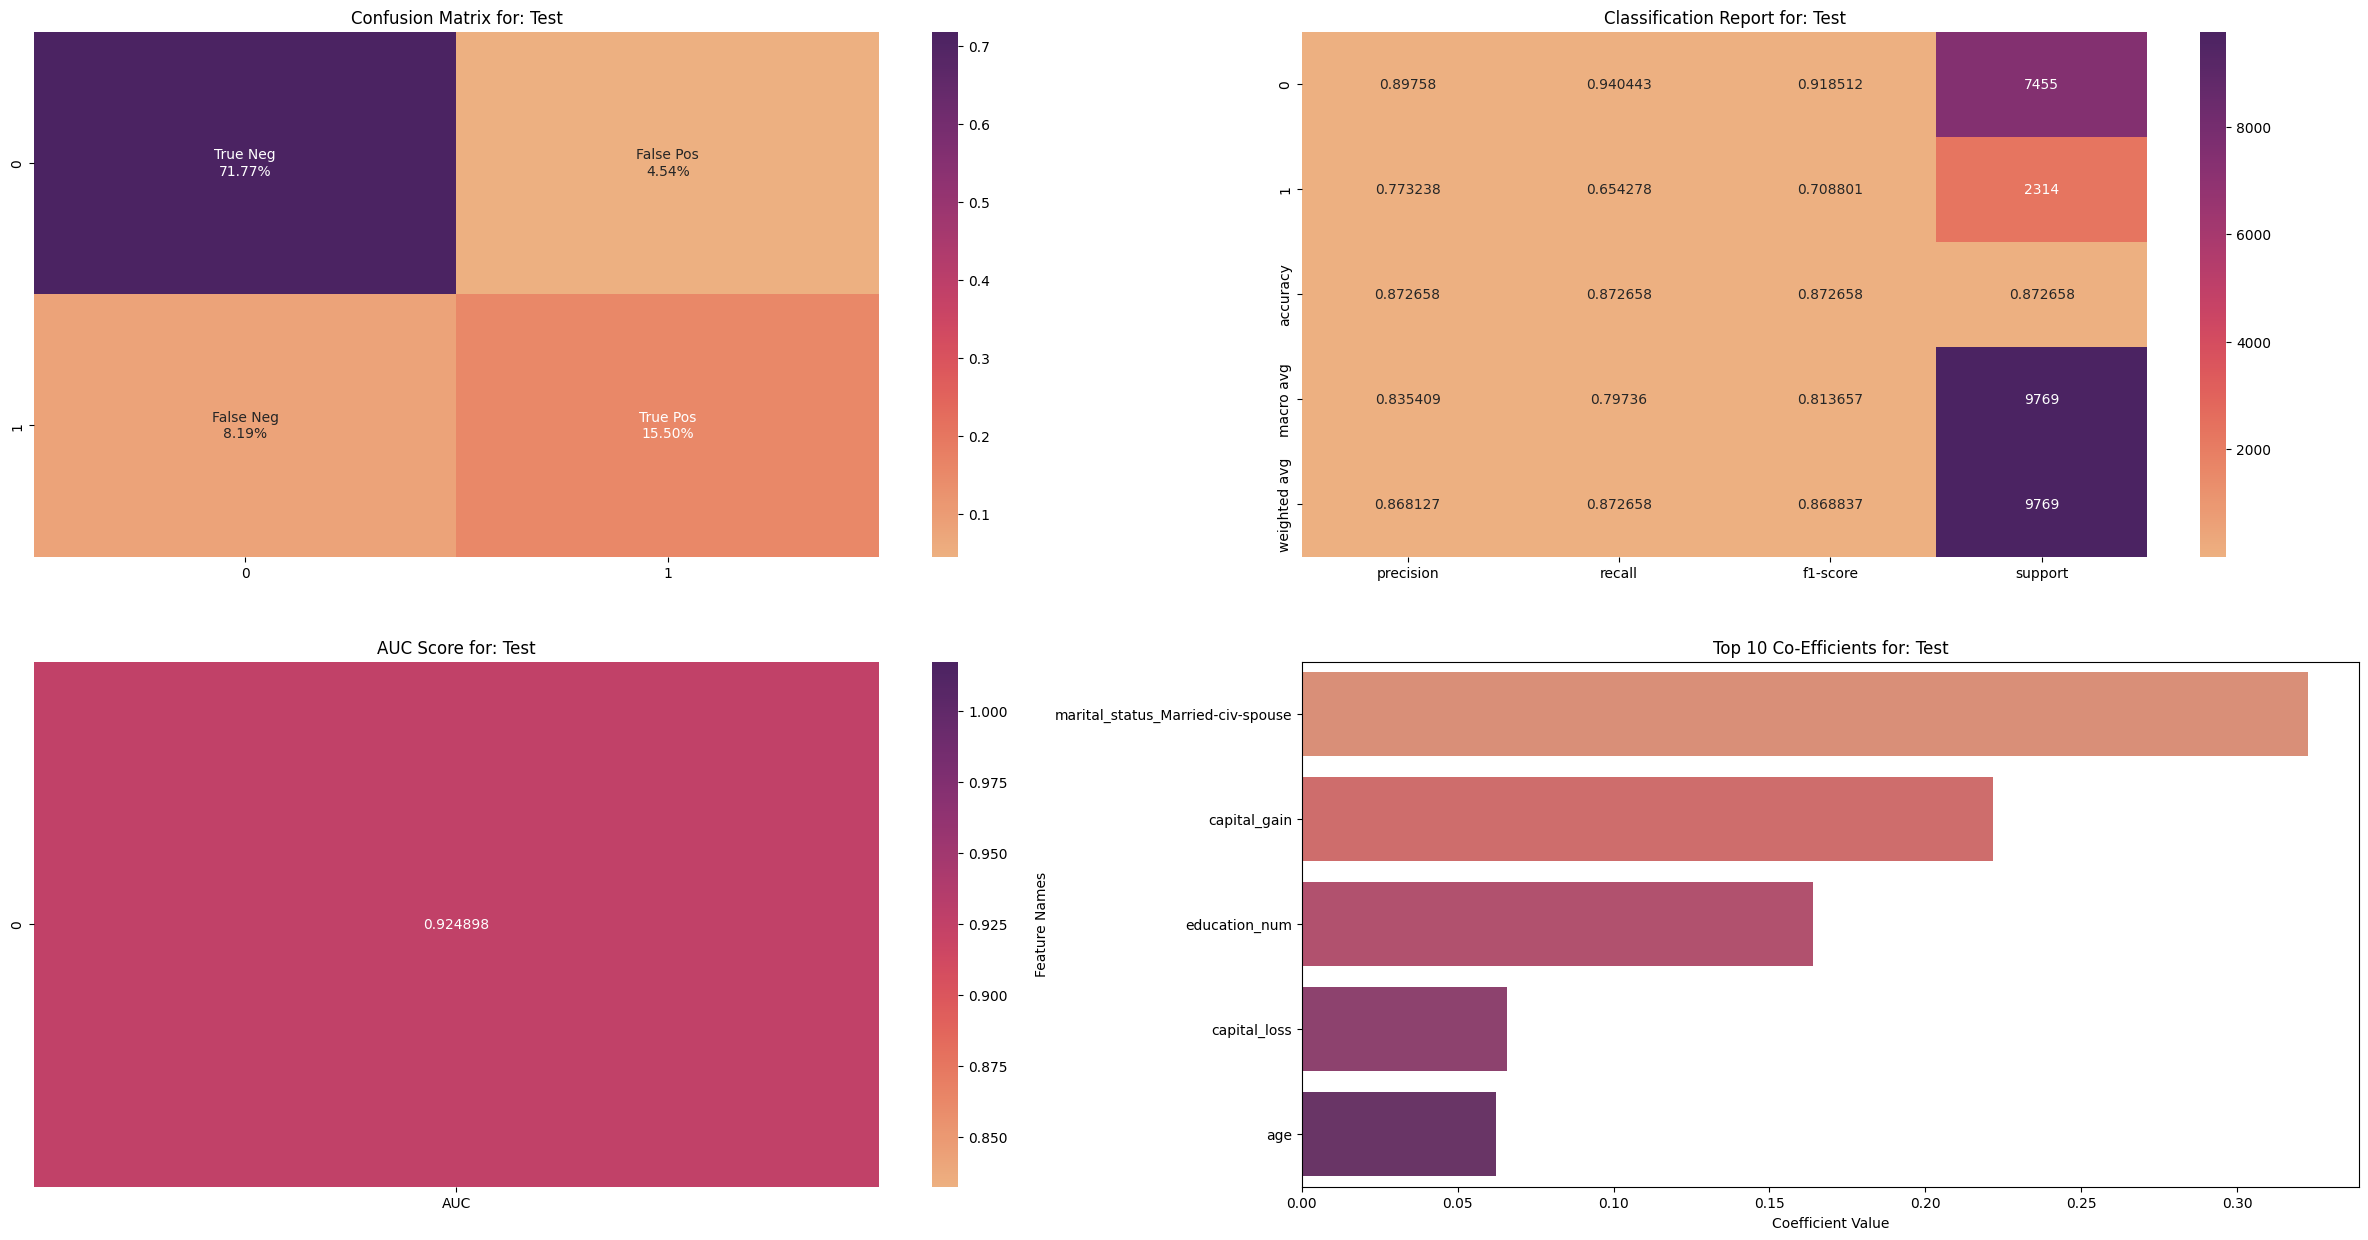

In [14]:
gbc,gbc_coeff_table = model_results(GradientBoostingClassifier(random_state=42),X_train,X_test,y_train,y_test,X_encoded.columns,grid_search=True,random_search=False,parameters=[{"n_estimators":[100,200,300,400],"learning_rate":[0.1,0.4,0.6],"max_depth":[1,2]}])

As the data is simillar we can conclude that it is not overfitting

## XGBoost

Random Search


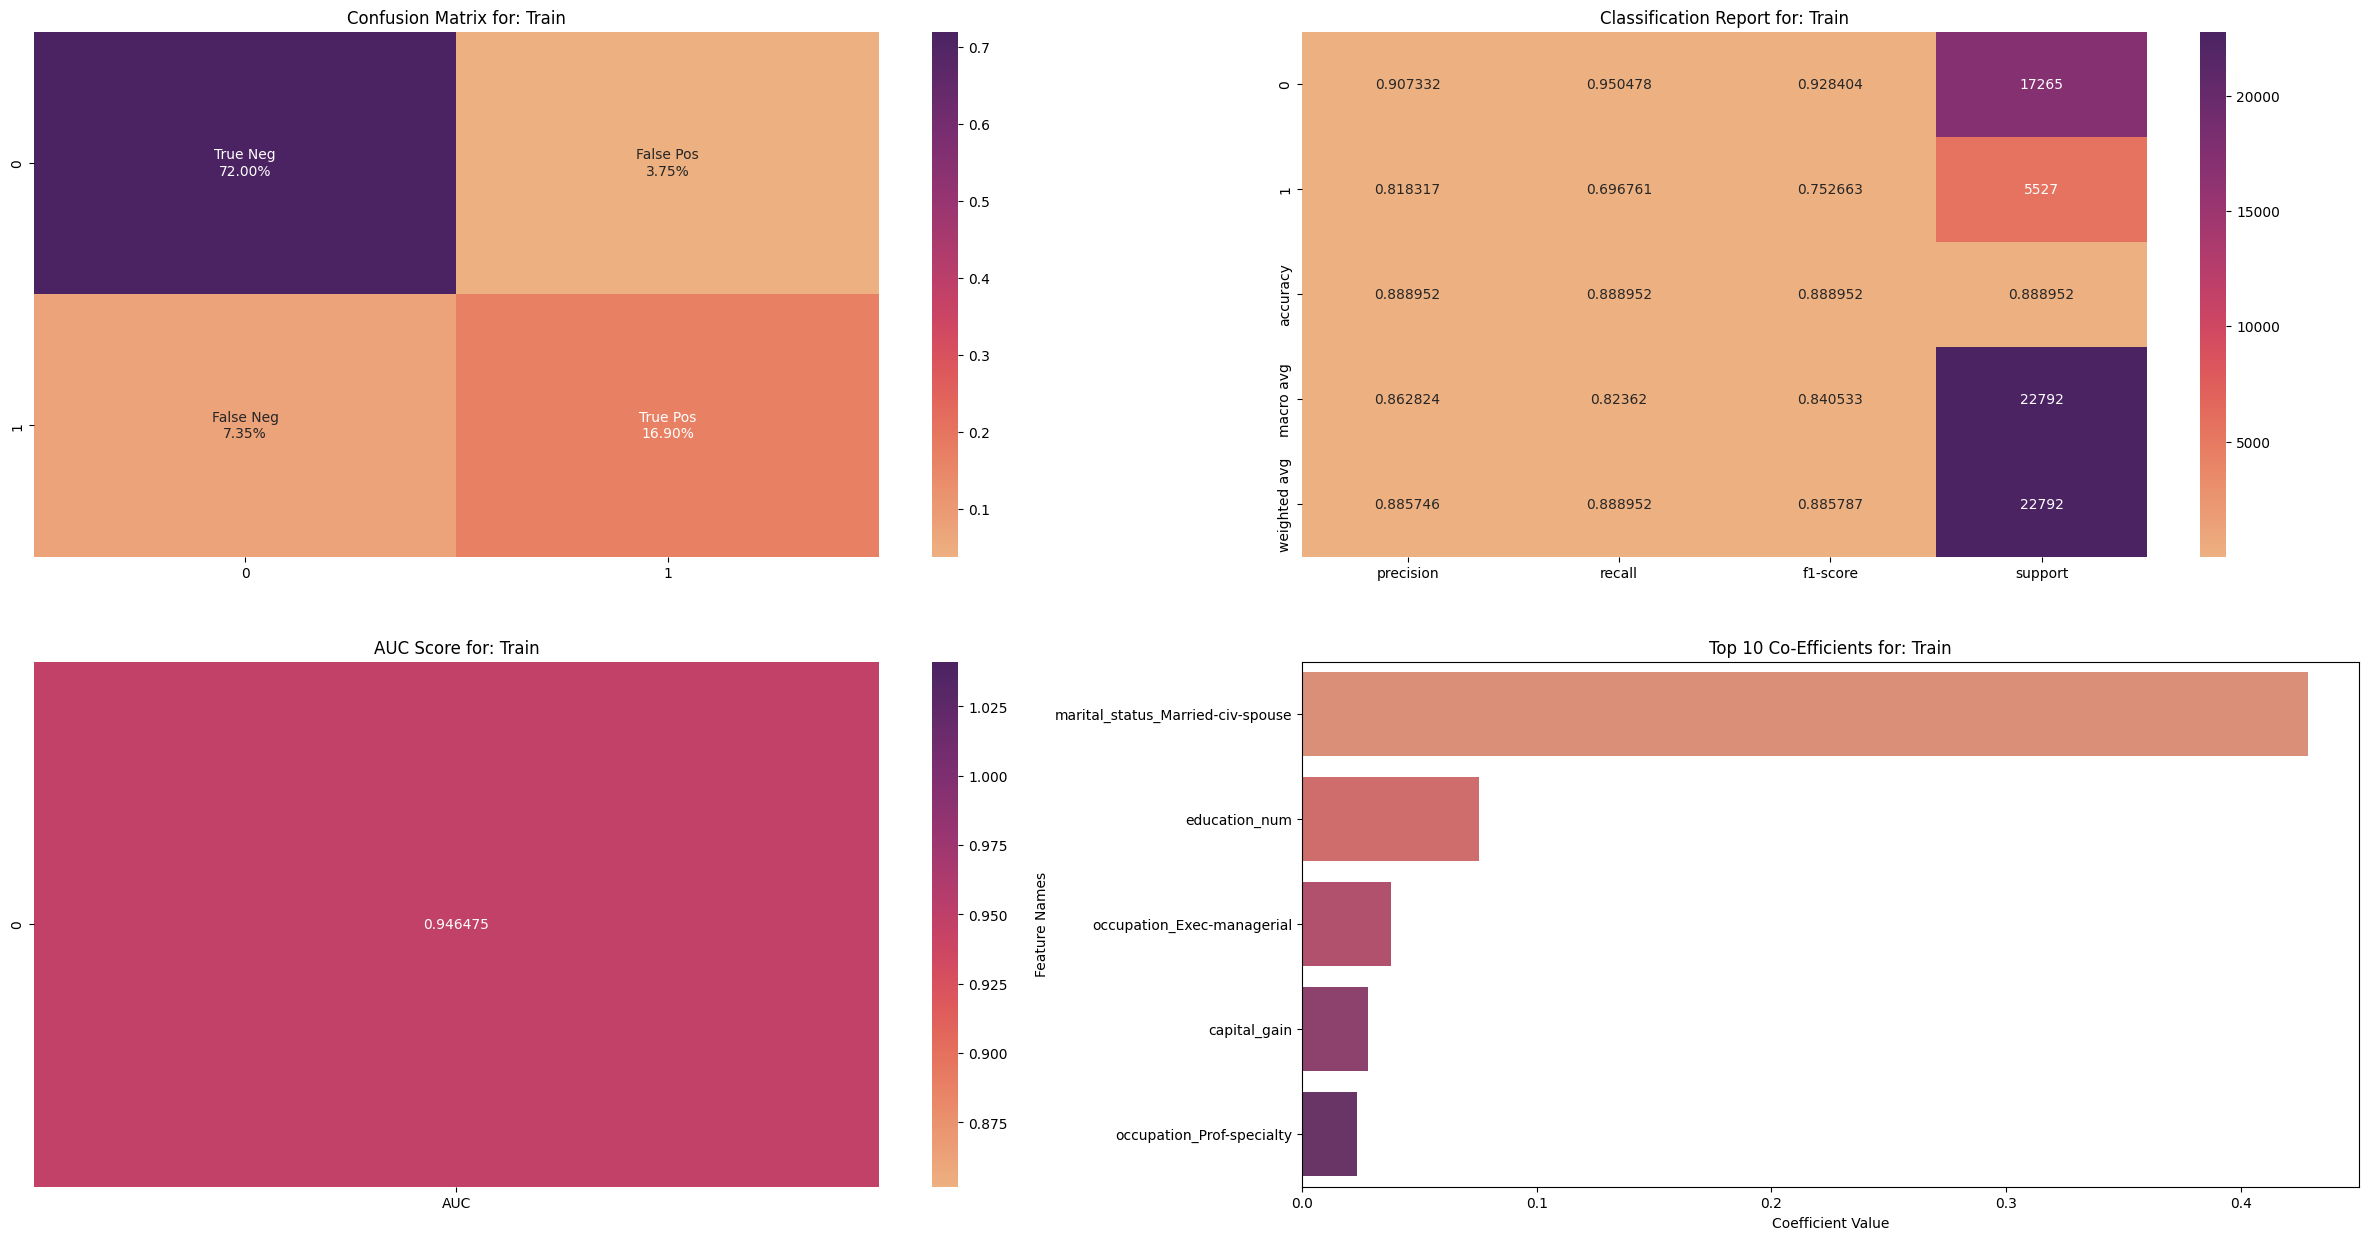

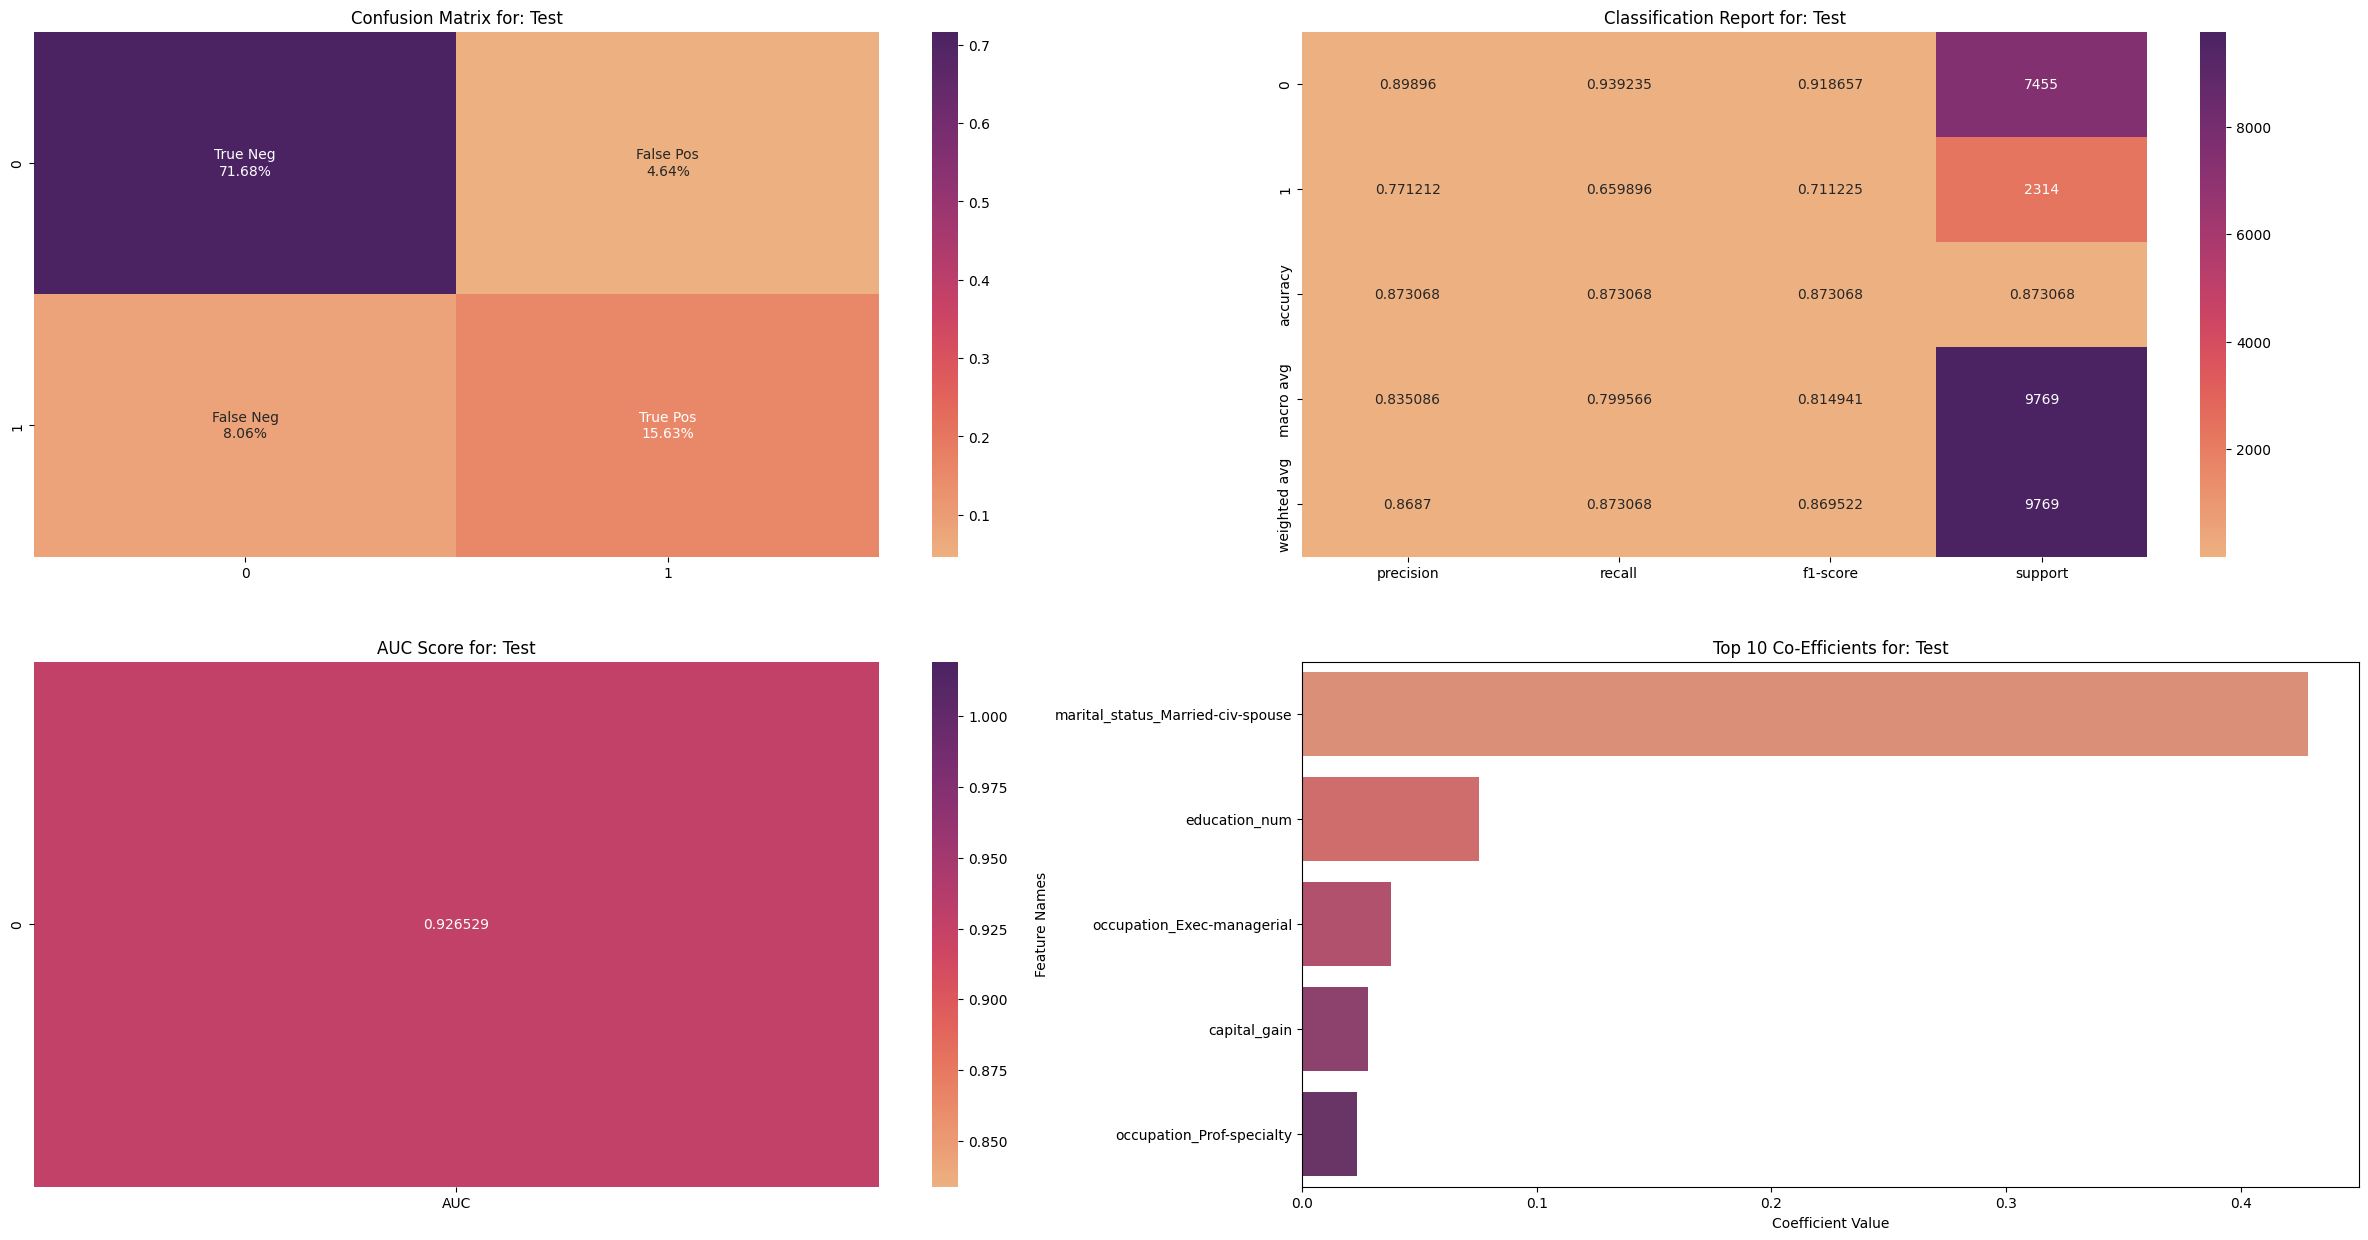

In [15]:
xgb,xgb_coeff_table = model_results(XGBClassifier(n_jobs=os.cpu_count(),random_state=42),X_train,X_test,y_train,y_test,X_encoded.columns,grid_search=False,random_search=True,parameters=[{"n_estimators":np.arange(100,1001,50),"learning_rate":np.arange(0.1,1.7,0.1),"max_depth":[1,2],"gamma":np.arange(0,5.25,0.25)}])

As the data is simillar we can conclude that it is not overfitting

# Conceptual Questions

#### 1) The lecture notes describe the Gini Index which is the default criterion used for splitting in sklearn's version of RandomForestClassifier. How does the Gini Index work? (i.e. How is it used to build a top-performing model?). 

To understand what Gini Index is, we must first understand the underlying concepts of Entropy and Information Gain. Entropy can be defined as the measurement of the impurity or randomness in the data points. It ranges from 0 to 1, with 0 usually 0 meaning no disorder and 1 meaning high disorder.
Information Gain is applied to quantify which feature provides maximal information about the classification based on the notion of entropy, i.e. by quantifying the size of uncertainty, disorder or impurity, in general, with the intention of decreasing the amount of entropy initiating from the top (root node) to bottom(leaves nodes).
The formula for entropy is given by $$ Entropy = -\sum^{n}_{i=1}p_{i}*Log_{2}\left(p_{i}\right) $$
here $p$ denotes the probability that it is a function of entropy. 

Gini Index, also known as Gini impurity, calculates the amount of probability of a specific feature that is classified incorrectly when selected randomly. If all the elements are linked with a single class then it can be called pure.Like the properties of entropy, the Gini index varies between values 0 and 1, where 0 expresses the purity of classification, i.e. All the elements belong to a specified class or only one class exists there. And 1 indicates the random distribution of elements across various classes. The value of 0.5 of the Gini Index shows an equal distribution of elements over some classes. While designing the decision tree, the features possessing the least value of the Gini Index would get preferred. Gini Index can be expressed as $$ Gini Index = 1 - \sum^{n}_{i=1}\left(P_{i}\right)^{2} $$

#### 2) Describe how Random Forest is different from bagging & why this difference can yield improved results.

Bagging is an ensemble algorithm that fits multiple models on different subsets of a training dataset, then combines the predictions from all models.
Like bagging, Random Forest involves selecting bootstrap samples from the training dataset and fitting a decision tree on each. The main difference is that all features are not used. Instead, a small, randomly selected subset of features is chosen for each bootstrap sample. This has the effect of de-correlating the decision trees, and in turn, improving the ensemble prediction. Thus the best split feature from the subset is used to split each node in a tree, unlike in bagging where all features are considered for splitting a node.


#### 3) Describe the importance of the max_depth parameter in Random Forest. Do not just provide a definition, rather think through how bias-variance tradeoff might be impacted by the max_depth parameter.

max_depth represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data. This works like a double edged sword, as the more information, the model captures the more tuned it's trees are to the data, and the less information it captures, the less the model is tuned to the data. A decision tree with a deeper maximum depth can capture more complex patterns in the data, but it is also more likely to overfit the training data, resulting in high variance. On the other hand, a decision tree with a shallower maximum depth may have higher bias but lower variance, as it is less likely to overfit the training data. This ends up being the same as with the bias variance trade-off that most other models face, with one crucial exception. Due to the bootstrap nature of a random forest, it is far more likely for the tree to converge than to ever reach a large enough max_depth. This is due to the random selection of data, thus essentially performing cross-validation while training, and thus reducing the chances of Over Fitting.

#### 4)What does the alpha parameter represent in AdaBoost? Please refer to chapter 7 of the Hands-On ML book if you are struggling.

The $ \alpha $ parameter in AdaBoost is the weight of the predictor. It is calculated as $$ \alpha _{j} = \frac{1}{2} * log\left(\frac{(1-Total Error)}{Total Error}\right) $$

Alpha is how much influence a stump will have in the final classification. Total Error is the total number of misclassifications for that training set divided by the training set size. Alpha will always be between -3 to 3, and can be easily found by  by plugging in various values of Total Error ranging from 0 to 1. When a Decision Stump does well, or has no misclassifications this results in an error rate of 0 and a relatively large, positive alpha value. If the stump just classifies half correctly and half incorrectly (an error rate of 0.5, no better than random guessing!) then the alpha value will be 0. Finally, when the stump ceaselessly gives misclassified results then the alpha would be a large negative value.

#### 5) In AdaBoost explain how the final predicted class is determined. Be sure to reference the alpha term in your explanation.

AdaBoost is a sequential boosting learner, that combines the multiple weak learners into a single learner. AdaBoost only deals with stumps, which are trees with only a single leaf node.

In the initial run, the weigts will be set to $\frac{1}{N}$ where $N$ is the total number of iterations. the following weights will be calulate by the equation:
$$W_{i}^{m} = \frac{1}{Z_{m}} \cdot W_{i}^{m-1} \cdot e^{-y_i\alpha_{m}h\left(x_i;\theta_m\right)}$$
The $\alpha$ can be calculated by:
$$\alpha_m = \frac{1}{2}log\left(\frac{(1-\epsilon_m)}{\epsilon_m}\right)$$
and the $\epsilon$ can be calculated by:
$$\epsilon_m = \frac{1}{2}\left(1 - \sum_{i=1}{n}W_{i}^{m-1}-y_i\alpha_{m}h\left(x_i;\theta_m\right)\right)$$

This will give the updated weights, and the subsequent stumps will be formed. To correct the previous error the observations that were incorrectly classified now carry more weight than the observations that were correctly classified.    


#### 6) In Gradient Boosting, what is the role of the max_depth parameter? Why is it important to tune on this parameter?

The max depth parameter in Gradient Boosting performs the exact same role as in random forests. Thus the effects of the max depth parameter influences the results of the model in simillar ways to a random forest model, with a large max depth likely causing the model to over fit, while smaller max depths usually result in underfitting. 

#### 7) In Part (e) of Steps 2-5 you determined the top 5 predictors across each model. Do any predictors show up in the top 5 predictors for all three models? If so, comment on if this predictor makes sense given what you are attempting to predict. (Note: If you don't have any predictors showing up across all 3 predictors, explain one that shows up in 2 of them).

1) Capital gain: High capital gain, should be correlated to a higher salary, as more affluent people tend to invest their salaries in a wide array of investments. 
2) Education Num: Higher education rates are highly correlated with an increase in the salary, as they can utilize their niche degrees for high paying jobs 
3) Married-Status-married civ spouse: Being married contributes a lot to the finances if they are both working.  

#### 8) From the models run in steps 2-5, which performs the best based on the Classification Report? Support your reasoning with evidence from your test data and be sure to share the optimal hyperparameters found from your grid search.

The XGBoost module runs the best, as it has the highest F-1 score of 0.711225. The F-1 score is the harmonic mean of the precision and recall, and is usually a very good metric for comparing against two models. A higher F-1 score indicates that not only is the model better at finding positive cases, it is also better at identifying them correctly. The optimal hyperparameters are shown below.

In [20]:
xgb.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=16, num_parallel_tree=None,
              predictor=None, random_state=42, ...)>

#### 9) For your best performing model, plot out a ROC curve using your test data. Feel free to use sklearn, matplotlib or any other method in python. Describe what the x-axis & y-axis of the ROC curve tell us about a classifier.

Text(0, 0.5, 'True Positive Rate')

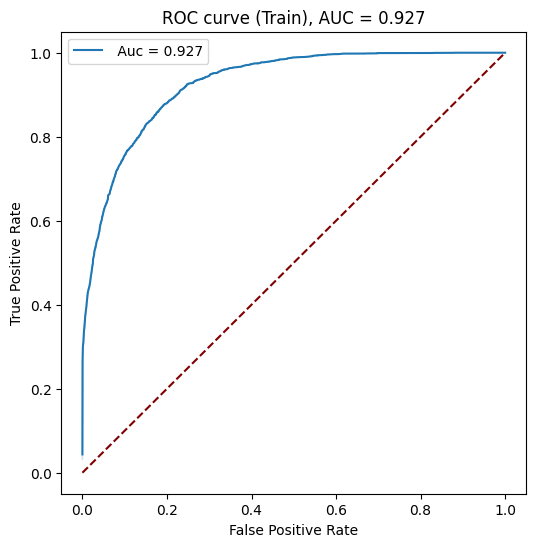

In [21]:
predict_proba_auc_test = xgb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test,predict_proba_auc_test[:,1])

roc_fig,axs = plt.subplots(1,1,figsize=(6,6))
auc_value = auc(fpr,tpr)
rounded_auc = round(auc_value.astype('float'),3)
curve1 = sns.lineplot(x=fpr, y=tpr,ax=axs,label=" Auc = "+repr(rounded_auc))
curve2 = sns.lineplot([0, 1], color='Maroon', linestyle='--',ax=axs)
axs.set_title('ROC curve (Train), AUC = '+repr(rounded_auc))
axs.set_xlabel("False Positive Rate")
axs.set_ylabel("True Positive Rate")

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. The curve plots two parameters, True Positive Rate and False Positive Rate. It shows the performance of the model at all thresholds, and informs the use what threshold to chose for his requirement.

True Positive Rate is the probability of a positive test result, conditioned on the individual truly being positive.
False Positive Rate is the probability of a positive test result, conditioned on the individual truly being negative